In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
customers = pd.read_csv('Customers.csv')
transactions = pd.read_csv('Transactions.csv')

# Merging the data
merged_data = transactions.merge(customers, on='CustomerID', how='left')

customer_data = merged_data.groupby('CustomerID').agg(
    total_spent=('TotalValue', 'sum'),
    avg_transaction_value=('TotalValue', 'mean'),
    transaction_count=('TransactionID', 'count')
).reset_index()

customer_data = customer_data.merge(
    customers[['CustomerID', 'Region', 'SignupDate']],
    on='CustomerID',
    how='left'
)
customer_data['SignupDate'] = pd.to_datetime(customer_data['SignupDate'])
customer_data['days_since_signup'] = (pd.Timestamp.today() - customer_data['SignupDate']).dt.days
customer_data.drop('SignupDate', axis=1, inplace=True)

customer_data = pd.get_dummies(customer_data, columns=['Region'], drop_first=True)

# Scaling the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(customer_data.drop('CustomerID', axis=1))

# Saving scaled data in a DataFrame for clustering
scaled_data = pd.DataFrame(scaled_features, columns=customer_data.columns[1:])

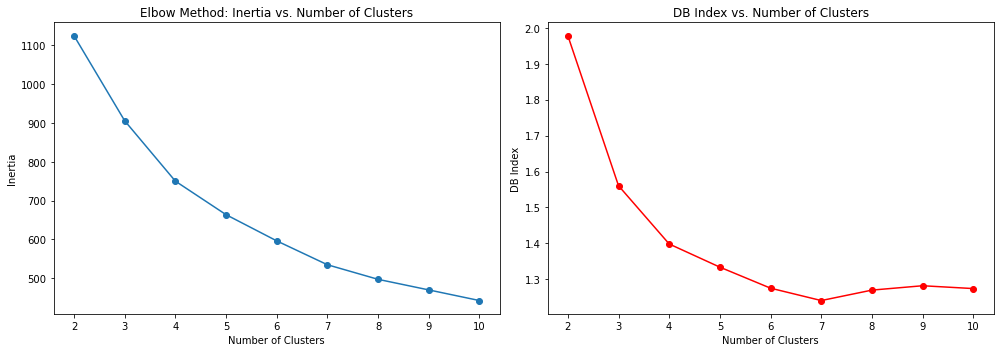

In [3]:
inertia = []
db_scores = []
silhouette_scores = []
k_values = range(2, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)
    db_scores.append(davies_bouldin_score(scaled_data, kmeans.labels_))
    silhouette_scores.append(silhouette_score(scaled_data, kmeans.labels_))

# Plotting the Elbow Curve and DB Index
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(k_values, inertia, marker='o')
plt.title('Elbow Method: Inertia vs. Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')

plt.subplot(1, 2, 2)
plt.plot(k_values, db_scores, marker='o', color='r')
plt.title('DB Index vs. Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('DB Index')
plt.tight_layout()
plt.show()

In [7]:
optimal_k = 5
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(scaled_data)
customer_data['Cluster'] = clusters

db_index = davies_bouldin_score(scaled_data, clusters)
print(f"Davies-Bouldin Index: {db_index}")
silhouette_avg = silhouette_score(scaled_data, clusters)
print(f"Silhouette Score: {silhouette_avg}")


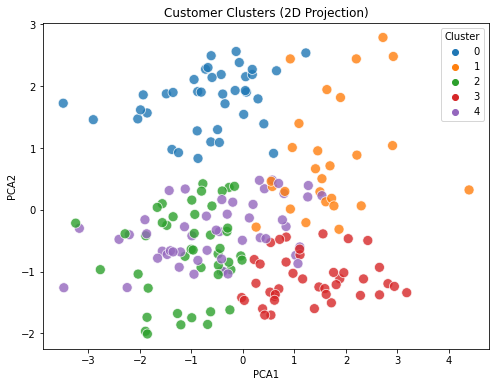

In [9]:
from sklearn.decomposition import PCA

# Reducing dimensions to 2D
pca = PCA(n_components=2)
pca_data = pca.fit_transform(scaled_data)
customer_data['PCA1'] = pca_data[:, 0]
customer_data['PCA2'] = pca_data[:, 1]

# Plotting clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x='PCA1', y='PCA2', hue='Cluster', data=customer_data,
    palette='tab10', s=100, alpha=0.8
)
plt.title('Customer Clusters (2D Projection)')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend(title='Cluster')
plt.show()